In [1]:
import matplotlib.pyplot as plt
#data manipulations
import numpy as np
import pandas as pd
#pytorch
import torchvision
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as f
from torchvision import transforms

#scraping from internet
from PIL import Image
#scraping from internet
import requests
from io import BytesIO
# time related
from timeit import default_timer as timer

In [2]:
IMAGE_SHAPE = (128, 128)

train_transform = transforms.Compose([
    transforms.Resize(IMAGE_SHAPE),
    transforms.RandomRotation(10),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize(IMAGE_SHAPE),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# datasets
trainset = torchvision.datasets.ImageFolder("../input/dataset/dataset/train", transform = train_transform)
validset = torchvision.datasets.ImageFolder("../input/dataset/dataset/val", transform = test_transform)
testset = torchvision.datasets.ImageFolder("../input/dataset/dataset/test", transform = test_transform)

#batches
batch_size = 16

# loaders for data
trainloader = torch.utils.data.DataLoader(trainset , batch_size=batch_size , shuffle = True)
validloader = torch.utils.data.DataLoader(validset , batch_size=batch_size , shuffle = True)
testloader = torch.utils.data.DataLoader(testset  , batch_size=batch_size)

16


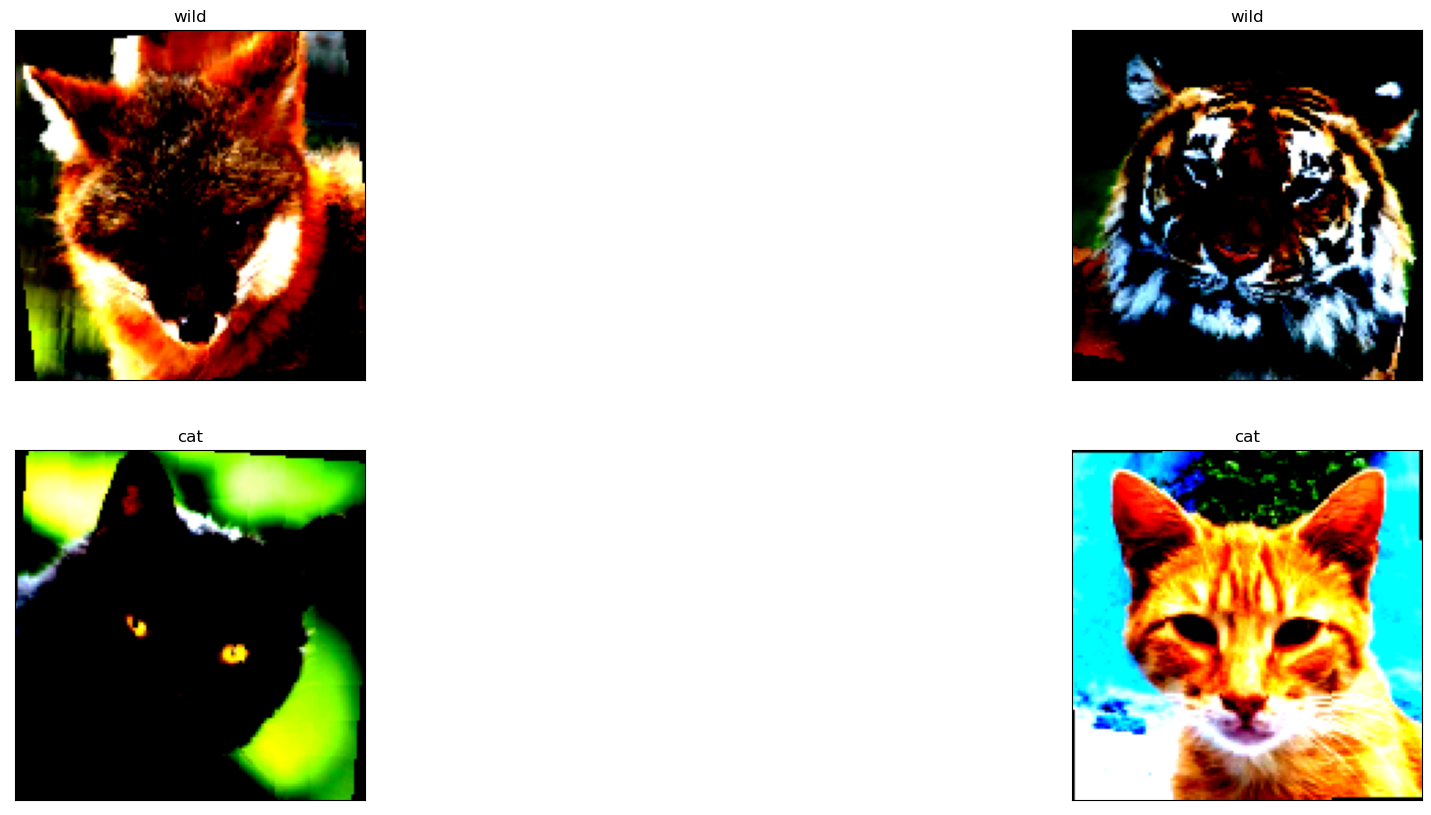

In [3]:
trainItr = iter(trainloader)
images, labels = next(trainItr)
print(len(images))
images, labels = images.numpy() , labels.numpy()


fig = plt.figure(figsize = (25,10))

for i in range(int(batch_size/4)):
    ax = fig.add_subplot(2 , int(batch_size/8) , i + 1 , xticks = [] , yticks = [])
    ax.imshow(np.transpose(images[i] , (1,2,0)))
    ax.set_title(trainset.classes[labels[i]])

In [4]:
print("Unique classes number : ",len(trainset.classes))
print("Classes : ", trainset.classes)

Unique classes number :  3
Classes :  ['cat', 'dog', 'wild']


In [5]:
my_gpu = torch.cuda.is_available()
device = torch.device('cuda' if my_gpu else 'cpu')
device

device(type='cuda')

In [6]:
from torchvision import models

num_classes = len(trainset.classes)
model = models.mobilenet_v2(weights='IMAGENET1K_V2')
model.classifier[1] = nn.Linear(1280, num_classes)
model = model.to(device)
model.eval()

Downloading: "https://download.pytorch.org/models/mobilenet_v2-7ebf99e0.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-7ebf99e0.pth


  0%|          | 0.00/13.6M [00:00<?, ?B/s]

MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

In [7]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [8]:
import csv
import os
from tqdm.auto import tqdm


open("/kaggle/working/training_logs-new.csv", "a", newline="")
log_file = open("/kaggle/working/training_logs-new.csv", "a", newline="")
csv_writer = csv.writer(log_file)
csv_writer.writerow(["epoch", "train_loss", "train_acc", "val_loss", "val_acc"])


def loop_fn(mode, dataset, dataloader, model, criterion, optimizer):
    if mode == 'train':
        model.train()
    elif mode == 'val':
        model.eval()
  
    loss = correct = 0
    for feature, target in tqdm(dataloader, desc=mode.title()):
        feature, target = feature.to(device), target.to(device)
        output = model(feature)
        loss = criterion(output, target)

        if mode == 'train':
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        
        loss += loss.item() * feature.shape[0]
        correct += (output.argmax(1) == target).sum().item()
    loss = loss/len(dataset)
    accuracy = correct/len(dataset)
    return loss, accuracy

num_epochs = 10
for epoch in range(1, num_epochs+1):
    train_cost, train_score = loop_fn('train', trainset, trainloader, model, criterion, optimizer)
    with torch.no_grad():
        test_cost, test_score = loop_fn('val', validset, validloader, model, criterion, optimizer)
    print(epoch, float(train_cost), train_score, float(test_cost), test_score)
    csv_writer.writerow([epoch, float(train_cost), train_score, float(test_cost), test_score])

Train:   0%|          | 0/807 [00:00<?, ?it/s]

Val:   0%|          | 0/101 [00:00<?, ?it/s]

1 0.0007079975912347436 0.8257769510966442 0.0012272084131836891 0.9013035381750466


Train:   0%|          | 0/807 [00:00<?, ?it/s]

Val:   0%|          | 0/101 [00:00<?, ?it/s]

2 0.000187812969670631 0.9228086491513602 8.334331505466253e-05 0.9385474860335196


Train:   0%|          | 0/807 [00:00<?, ?it/s]

Val:   0%|          | 0/101 [00:00<?, ?it/s]

3 7.195216767286183e-06 0.9460590560334806 0.00024383132404182106 0.9130974549968963


Train:   0%|          | 0/807 [00:00<?, ?it/s]

Val:   0%|          | 0/101 [00:00<?, ?it/s]

4 8.474261267110705e-05 0.9504766333410835 0.003914677072316408 0.9714463066418374


Train:   0%|          | 0/807 [00:00<?, ?it/s]

Val:   0%|          | 0/101 [00:00<?, ?it/s]

5 1.0532839041843545e-05 0.9593117879562892 2.122857267750078e-06 0.9757914338919925


Train:   0%|          | 0/807 [00:00<?, ?it/s]

Val:   0%|          | 0/101 [00:00<?, ?it/s]

6 0.00017502167611382902 0.96202433542587 0.00010137132630916312 0.9819987585350713


Train:   0%|          | 0/807 [00:00<?, ?it/s]

Val:   0%|          | 0/101 [00:00<?, ?it/s]

7 5.21399597346317e-05 0.9649693869642719 1.1658797120617237e-05 0.9708255741775295


Train:   0%|          | 0/807 [00:00<?, ?it/s]

Val:   0%|          | 0/101 [00:00<?, ?it/s]

8 0.0007495900499634445 0.9680694412152213 2.6704105039243586e-05 0.9584109248913718


Train:   0%|          | 0/807 [00:00<?, ?it/s]

Val:   0%|          | 0/101 [00:00<?, ?it/s]

9 5.947496902081184e-06 0.9683794466403162 0.002005035988986492 0.9795158286778398


Train:   0%|          | 0/807 [00:00<?, ?it/s]

Val:   0%|          | 0/101 [00:00<?, ?it/s]

10 4.424284634296782e-05 0.9708594900410757 0.00024033711815718561 0.9702048417132216


In [9]:
torch.save(model.state_dict(), f"/kaggle/working/_e{epoch}.pth")

In [12]:
PRETRAINED_MODEL = "/kaggle/input/logs-animal-faces-transfer-learning/logs/_e10.pth"

In [14]:
from torchvision import models
import torch.nn.functional as F
from collections import OrderedDict
my_gpu = torch.cuda.is_available()
device = torch.device('cuda' if my_gpu else 'cpu')
device
model = models.mobilenet_v2(num_classes=len(testset.classes),pretrained=False)
model = model.to(device)
model.load_state_dict(torch.load(PRETRAINED_MODEL))
model.eval()

MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

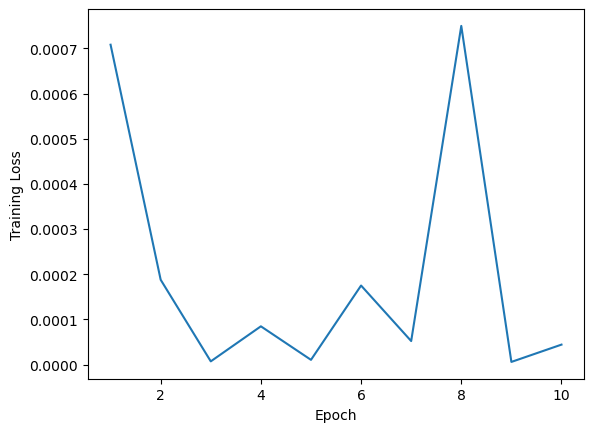

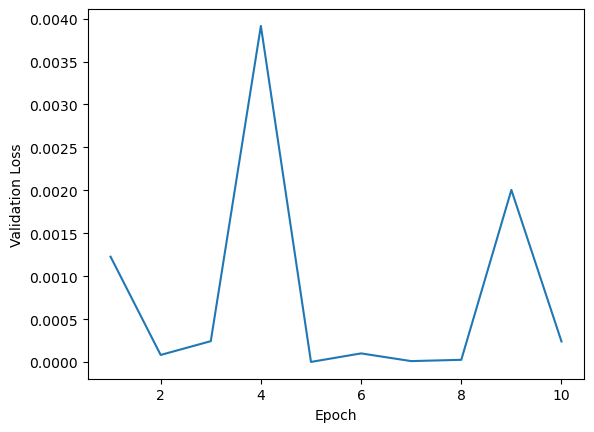

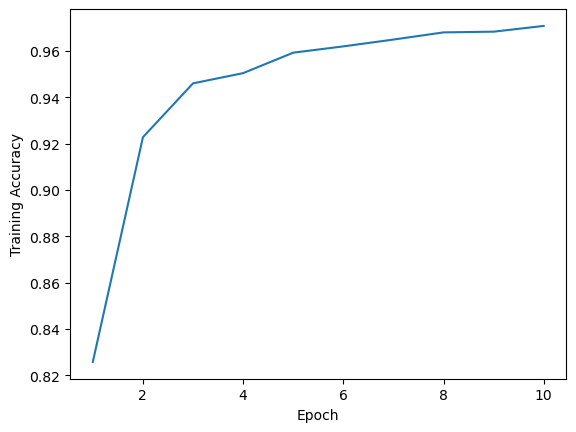

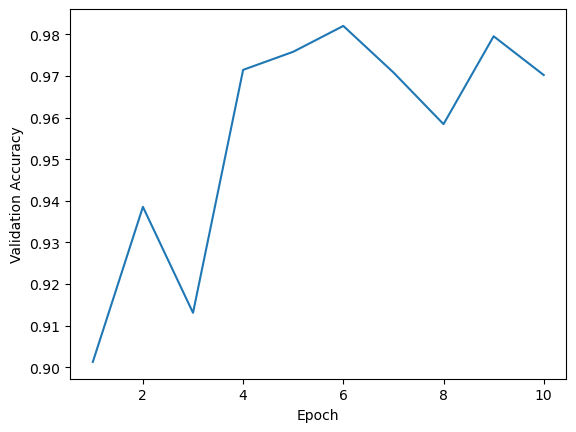

In [15]:
import pandas as pd

df = pd.read_csv("/kaggle/input/logs-animal-faces-transfer-learning/logs/training_logs.csv")

plt.figure("Epoch vs Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.plot(df["epoch"], df["train_loss"])
plt.show()

plt.figure("Epoch vs Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Validation Loss")
plt.plot(df["epoch"], df["val_loss"])
plt.show()

plt.figure("Epoch vs Training Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Training Accuracy")
plt.plot(df["epoch"], df["train_acc"])
plt.show()

plt.figure("Epoch vs Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Validation Accuracy")
plt.plot(df["epoch"], df["val_acc"])
plt.show()

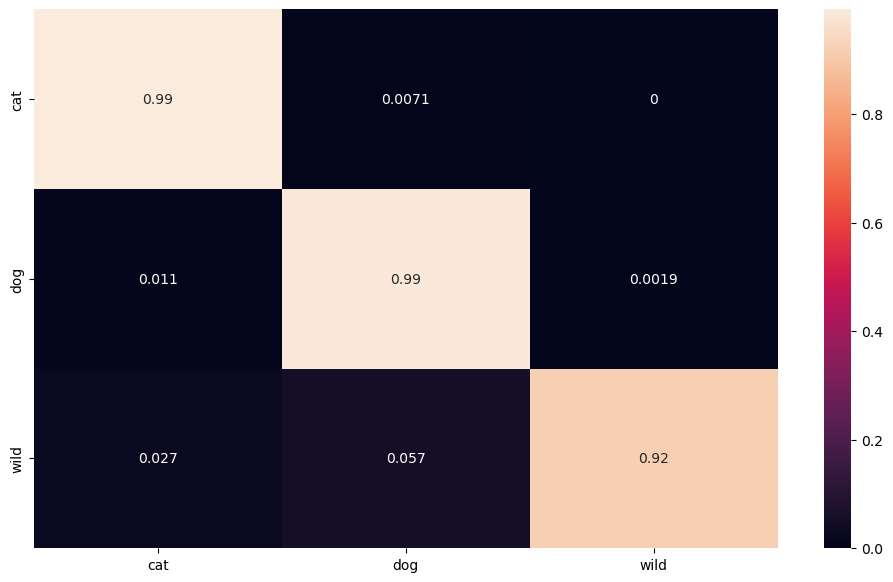

In [16]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

y_pred = []
y_true = []

# iterate over test data
for data in testloader:
        inputs, labels = data[0].to(device), data[1].to(device)
        output = model(inputs) # Feed Network

        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred.extend(output) # Save Prediction
        
        labels = labels.data.cpu().numpy()
        y_true.extend(labels) # Save Truth

# constant for classes
classes = testset.classes

# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None], index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (12,7))
sn.heatmap(df_cm, annot=True)
plt.savefig('output.png')

In [17]:
from sklearn.metrics import accuracy_score, classification_report

# print accuracy
print("Overall Accuracy: ", round(accuracy_score(y_true, y_pred)*100,2)," %")

# print precision, recall, F1-score per each class/tag
print(classification_report(y_true, y_pred,target_names=trainset.classes))

Overall Accuracy:  96.6  %
              precision    recall  f1-score   support

         cat       0.97      0.99      0.98       566
         dog       0.94      0.99      0.96       525
        wild       1.00      0.92      0.96       525

    accuracy                           0.97      1616
   macro avg       0.97      0.97      0.97      1616
weighted avg       0.97      0.97      0.97      1616

